# Otimização do sistema de manutenção de caminhões

Nessa análise nós exploramos uma base de dados sobre os veículos da frota. 

O principal objetivo é aplicar técnicas de Machine Learing para prever os veículos que precisarão de manutenção, reduzindo assim os custos da empresa. 

Também iremos investigar quais são as principais váriaveis na predição da manutenção de um veículo.

## Carregamento dos dados

In [24]:
# importa as principais bibliotecas que serão utilizadas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# carrega os dados pré 2020
df_pre = pd.read_csv('data_pre_2020.csv')

# carrega os dados de 2020
df = pd.read_csv('data_2020.csv')

## Explorando os dados

In [26]:
df_pre.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,na,2130706438,280,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,neg,41040,na,228,100,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,neg,12,0,70,66,0,10,0,0,0,...,240,46,58,44,10,0,0,0,4,32
4,neg,60874,na,1368,458,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


In [27]:
# verifica o número de dados faltantes em cada coluna
num_falt = (df_pre == 'na').sum()
print(num_falt)

class         0
aa_000        0
ab_000    46329
ac_000     3335
ad_000    14861
          ...  
ee_007      671
ee_008      671
ee_009      671
ef_000     2724
eg_000     2723
Length: 171, dtype: int64


In [28]:
# verifica quantas colunas apresentam mais de 5% (3000) dos dados faltantes 
zero = sum(num_falt == 0)
menos_de_3000 = sum(num_falt < 3000) 
mais_de_3000 = sum(num_falt > 3000)
      
print('Existem: {} colunas sem nenhum dado faltante \n'.format(zero))        
print('{} colunas com menos de 3000 dados faltantes \n'.format(menos_de_3000))  
print('{} colunas com mais de 3000 dados faltantes \n'.format(mais_de_3000))        

Existem: 2 colunas sem nenhum dado faltante 

129 colunas com menos de 3000 dados faltantes 

42 colunas com mais de 3000 dados faltantes 



Iremos remover as colunas com mais de 3000 dados faltantes

In [29]:
# colunas com mais de 3000 dados faltantes
col = []

for i in range(len(num_falt)):
    if num_falt[i] > 3000:
        col.append((num_falt.index)[i])

In [30]:
# remove as colunas
df_pre.drop(col, axis = 1, inplace = True)

Para as demais colunas com dados faltantes iremos preenchê-los com a média da coluna

In [31]:
# mapeia as strings 'neg' e 'pos' da coluna 'class' nos valores 0 e 1, respectivamente
df_pre['class'] = df_pre['class'].map({'neg' : 0, 'pos' : 1})

# subsititui as strings 'na' por np.NaN
df_pre = df_pre.replace('na', np.NaN)

In [32]:
# transforma todos os dados em float
df_pred = df_pre.astype(float)

In [33]:
# substitui os valores faltantes pelas médias das colunas
df_pred = df_pred.fillna(df_pred.mean())

## Machine Learning

Queremos desenvolver um modelo de classificação para prever os veículos que precisarão de manutenção

In [34]:
# normalização das variáveis
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df_pred)
df_pred_rescaled = pd.DataFrame(scaler.transform(df_pred))

In [35]:
# importando as bibliotecas de alguns modelos de classificassão
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

In [36]:
# define o método de validação do modelo, utilizamos Kfold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold

validacao = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1)

In [38]:
def teste_modelos(var_pred, var_resp):
  """
      Aplica diferentes modelos de classificação nos dados de entrada e retorna um DataFrame 
      com as métricas de avaliação dos modelos.
  """  

  lista_de_medidas = ['accuracy', 'recall', 'precision', 'balanced_accuracy', 'f1']
  nome_das_medidas = ['acurácia', 'sensibilidade', 'precisão', 'eficiência', 'f1-score']

  lista_de_modelos = [    DecisionTreeClassifier(max_depth = 7),
                          BaggingClassifier(),
                          RandomForestClassifier(n_estimators=50, max_depth = 5)]

  nome_dos_modelos = [    'Árvore (prof = 7)',
                          'Bagging',
                          'Random Forest (arvs = 50, prof = 5)']

  resultados0 = {}

  for i in range(len(lista_de_modelos)):

      print('Rodando modelo: ' + nome_dos_modelos[i])

      accs_vc = cross_validate(lista_de_modelos[i], var_pred, var_resp, cv = validacao, scoring = lista_de_medidas)

      acc = accs_vc['test_accuracy'].mean()
      sen = accs_vc['test_recall'].mean()
      vpp = accs_vc['test_precision'].mean()
      bac = accs_vc['test_balanced_accuracy'].mean()
      f1s = accs_vc['test_f1'].mean()

      resultados0[nome_dos_modelos[i]] = [acc, sen, vpp, bac, f1s]
      
      
  return pd.DataFrame(resultados0, index = nome_das_medidas).T


In [41]:
# define as variáveis preditoras e a variável resposta
X = df_pred_rescaled.drop(0, axis = 1)
y = df_pred_rescaled[0]

In [42]:
resultados = teste_modelos(X, y)
resultados.sort_values(by = 'sensibilidade', ascending = False)

Rodando modelo: Árvore (prof = 7)
Rodando modelo: Bagging
Rodando modelo: Random Forest (arvs = 50, prof = 5)


,acurácia,sensibilidade,precisão,eficiência,f1-score
Bagging,0.992933,0.674,0.875858,0.836169,0.760146
Árvore (prof = 7),0.991217,0.612,0.816168,0.804822,0.698873
"Random Forest (arvs = 50, prof = 5)",0.991000,0.519,0.902279,0.759000,0.656568


Dos modelos testados o Bagging foi o que apresentou a maior "sensibilidade", que é a métrica mais relevante para esse problema. 

A "sensibilidade" nos dá a fração dos veículos que apresentaram defeito no sistema de ar que o modelo é capaz de prever.

Aplicaremos então um modelo de Bagging para os dados de 2020.


## Pré-processamento dos dados de 2020

In [43]:
# remove as colunas pré-determinadas na análise dos dados pré 2020
df.drop(col, axis = 1, inplace = True)

In [44]:
# mapeia as strings 'neg' e 'pos' da coluna 'class' nos valores 0 e 1, respectivamente
df['class'] = df['class'].map({'neg' : 0, 'pos' : 1})

# subsititui as strings 'na' por np.NaN
df = df.replace('na', np.NaN)

In [45]:
# transforma todos os dados em float
df = df.astype(float)

In [46]:
# substitui os valores faltantes pelas médias das colunas
df = df.fillna(df.mean())

In [47]:
# normalização das variáveis
df_rescaled = pd.DataFrame(scaler.transform(df))

## Aplicando o modelo nos dados de 2020

In [51]:
# define o modelo
bagging = BaggingClassifier()

In [52]:
# ajusta o modelo em toda a base pré 2020
bagging.fit(X, y)

BaggingClassifier()

In [53]:
# define as variáveis preditivas e de resposta dos dados de 2020
X_2020 = df_rescaled.iloc[:, 1:]
y_2020 = df_rescaled.iloc[:, 0]

In [54]:
# predição 
pred_2020 = bagging.predict(X_2020)

In [55]:
from sklearn import metrics
# calcula a sensibilidade/recall do modelo quando aplicado nos dados de 2020
sens = metrics.recall_score(y_2020, pred_2020)
print('O modelo é capaz de prever {:.2%} dos veículos que precisaram de manutenção em 2020.'.format(sens))

O modelo é capaz de prever 69.87% dos veículos que precisaram de manutenção em 2020.


## Considerações sobre os resultados do modelo e os valores gastos 

In [56]:
# número de previsões positivas
pred_pos = sum(pred_2020 == 1)

# número de positivos nos dados
num_pos = sum(y_2020 == 1)

print('O modelo prediz a manutenção de {} veículos e os dados apresentam {} veículos que precisaram de manutenção.'.format(pred_pos, num_pos))

O modelo prediz a manutenção de 278 veículos e os dados apresentam 375 veículos que precisaram de manutenção.


In [59]:
# número de veículos preditos corretamente
corr_pos = sens * num_pos

# número de veículos que precisaram de manutenção mas não foram preditos
nao_pred = num_pos - corr_pos

print('O modelo prediz corretamente {} veículos que precisaram de manutenção e {} veículos \n precisaram de manutenção mas não foram preditos.'.format(corr_pos, nao_pred))

O modelo prediz corretamente 262.0 veículos que precisaram de manutenção e 113.0 veículos 
 precisaram de manutenção mas não foram preditos.


In [61]:
# valor manutenção preventiva
v1 = 10
#valor manutenção corretiva
v2 = 500

# valor gasto
total = pred_pos * v1 + nao_pred * v2

print('Se as manutenções fossem realizadas conforme as predições do modelo a empresa teria gastado ${}.'.format(total))

Se as manutenções fossem realizadas conforme as predições do modelo a empresa teria gastado $59280.0.


In [62]:
# valor que foi gasto em 2020
gasto_2020 = 187500

# valor economizado
economia = gasto_2020 - total

print('A economia teria sido de ${}.'.format(economia))

A economia teria sido de $128220.0.


## Variáveis de importância

In [63]:
# calcula a importância relativa das variáveis
feature_importances = np.mean([tree.feature_importances_ for tree in bagging.estimators_], axis=0)

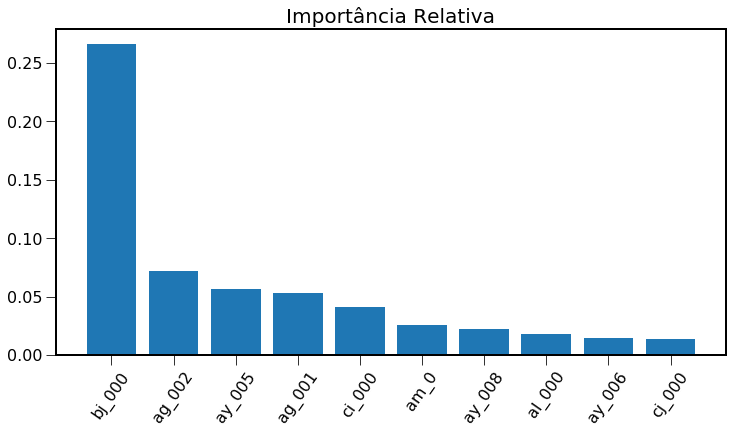

In [64]:
# ordena as variáveis em ordem ascendente de importância
sorted_feat_imp = np.sort(feature_importances)

# guarda a nova ordem dos índices após o reordenamento
arg = feature_importances.argsort()

# retorna o nome das variáveis
feature_names = df_pre.drop('class', axis = 1).columns

# reordena os nomes de acordo com o ordenamento de importância
sorted_feat_names = feature_names[arg]

# número de variáveis para serem exibidas no boxplot com as importâncias relativas
num_features = 10

# barplot da importância relativa
fig = plt.figure(figsize = (12, 6))
plt.bar(sorted_feat_names[::-1][:num_features], sorted_feat_imp[::-1][:num_features])
plt.xticks(fontsize = 16, rotation = 55)
plt.yticks(fontsize = 16)
plt.title('Importância Relativa', fontsize = 20)
plt.show()

A variável bj_000 é a variável de maior importância na predição das manutenções e com grande superioridade sobre as demais. 

Em seguida temos ag_002, ay_005, ag_001 e ci_000 que ainda apresentam certa relevância.

O gráfico também apresenta as outras 5 variáveis dentro das 10 mais relevantes mas a relevânancia se torna muito pequena.

